# Machine Learning to Predict Brittleness from other Geophysical Logs

## Data: 4 wells from the Appalachian Basin

In [3]:
import os
import pandas as pd

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor as gbR, GradientBoostingClassifier as gbC, IsolationForest
from sklearn.svm import SVC, SVR
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.feature_selection import mutual_info_regression

pd.set_option('display.max_columns', None)   #to display all the column information
pd.options.display.max_seq_items = 2000

### Load data

In [4]:
file_directory = r"../Thesis work/Thesis work/Well_Data_CSV_Merged"    #for macbook google drive

file_name1 = "Poseidon.csv"
file_name2 = "Boggess.csv"
file_name3 = "Mip3h.csv"
file_name4 = "Whipkey.csv"

file_name = [file_name1, file_name2, file_name3, file_name4]
data = []

for i in file_name:
    file_path = os.path.join(file_directory,i)
    df = pd.read_csv(file_path)
    data.append(df)

In [5]:
data_poseidon = data[0]
data_boggess = data[1]
data_mip3h = data[2]
data_whipkey = data[3]

In [6]:
# ## Marcellus Shale interval
# data_poseidon = data_poseidon.loc[(data_poseidon['DEPT'] > 7880) & (data_poseidon['DEPT'] < 8040)]
# data_boggess = data_boggess.loc[(data_boggess['DEPT'] > 7880) & (data_boggess['DEPT'] < 7970)]
# data_mip3h = data_mip3h.loc[(data_mip3h['DEPT'] > 7450) & (data_mip3h['DEPT'] < 7560)]
# data_whipkey = data_whipkey.loc[(data_whipkey['DEPT'] > 7730) & (data_whipkey['DEPT'] < 7840)]

In [7]:
print("The Poseidon data has {} rows".format(data_poseidon.shape[0]))
print("The Boggess data has {} rows".format(data_boggess.shape[0]))
print("The Mip3h data has {} rows".format(data_mip3h.shape[0]))
print("The Whipkey data has {} rows".format(data_whipkey.shape[0]))

The Poseidon data has 1910 rows
The Boggess data has 2851 rows
The Mip3h data has 2001 rows
The Whipkey data has 1141 rows


# Input and Output of the Model

### Data for Regression task

In [8]:
features =  ['DEPT', 'GR', 'NPHI','RHOZ', 'HCAL', 'DTCO','PEFZ','Brittleness_new']   #list of the features names to select
# features =  ['DEPT', 'GR','RHOZ', 'HCAL', 'NPHI','DTCO', 'Brittleness_new']   #list of the features names to select
target = 'Brittleness_new'   #name of the output feature

In [9]:
data = pd.concat([data_whipkey,
                  data_boggess,
                  data_poseidon], ignore_index=True)
data = data.loc[: ,features]

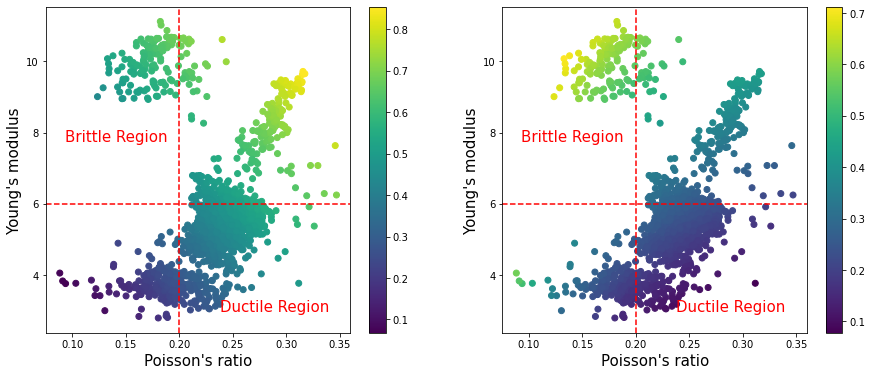

In [10]:
fig, ax = plt.subplots(1, 2, figsize = (15,6))

m = ax[0].scatter(data_poseidon.PR_DYN, data_poseidon.YME_DYN, c = data_poseidon.Brittleness)
ax[0].set_xlabel("Poisson's ratio", fontsize =15)
ax[0].set_ylabel("Young's modulus", fontsize =15)
ax[0].axhline(y=6, color='r', linestyle='--')
ax[0].axvline(x=0.2, color='r', linestyle='--')
ax[0].text(0.23, 0.6, 'Brittle Region',fontsize=15, horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes, c='r')
ax[0].text(0.75, 0.08, 'Ductile Region',fontsize=15, horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes, c='r')

l = ax[1].scatter(data_poseidon.PR_DYN, data_poseidon.YME_DYN, c = data_poseidon.Brittleness_new)
ax[1].set_xlabel("Poisson's ratio", fontsize =15)
ax[1].set_ylabel("Young's modulus", fontsize =15)
ax[1].axhline(y=6, color='r', linestyle='--')
ax[1].axvline(x=0.2, color='r', linestyle='--')
ax[1].text(0.23, 0.6, 'Brittle Region',fontsize=15, horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes, c='r')
ax[1].text(0.75, 0.08, 'Ductile Region',fontsize=15, horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes, c='r')

fig.colorbar(l, ax = ax[1])
fig.colorbar(m, ax = ax[0])

# fig.savefig(r'./Images/{}.png'.format('YME-PR plot'), dpi=300)

In [11]:
data[data < 0] = np.nan  #remove negative values
data.dropna(inplace = True)

In [12]:
data.shape

(5793, 8)

In [13]:
data.describe()

,DEPT,GR,NPHI,RHOZ,HCAL,DTCO,PEFZ,Brittleness_new
count,5793.000000,5793.000000,5793.000000,5793.000000,5793.000000,5793.000000,5793.000000,5793.000000
mean,7559.714742,140.870859,0.179506,2.678442,8.627467,73.640156,3.965914,0.267769
std,371.574779,60.494263,0.067303,0.074486,0.492982,10.250844,0.630845,0.130618
min,6740.000000,24.075700,0.000096,2.293725,7.593700,49.559100,2.320498,0.062834
25%,7273.500000,110.994800,0.166478,2.628825,8.476611,70.043050,3.703000,0.185308
50%,7563.000000,145.577000,0.202762,2.693238,8.564872,73.185910,3.948600,0.231757
75%,7852.500000,164.288600,0.221414,2.738316,8.850667,79.272160,4.208100,0.303143
max,8311.000000,780.629300,0.380134,3.116700,10.353190,105.446700,9.695100,0.933032


In [14]:
#add correlation plot
data.corr(method = 'spearman')

,DEPT,GR,NPHI,RHOZ,HCAL,DTCO,PEFZ,Brittleness_new
DEPT,1.000000,-0.342221,-0.524318,-0.680053,-0.111357,-0.020892,-0.062978,0.563437
GR,-0.342221,1.000000,0.676861,-0.074609,0.227490,0.675946,-0.040147,-0.670945
NPHI,-0.524318,0.676861,1.000000,0.276790,0.062021,0.543124,0.225312,-0.758868
RHOZ,-0.680053,-0.074609,0.276790,1.000000,0.115628,-0.379835,0.343675,-0.322943
HCAL,-0.111357,0.227490,0.062021,0.115628,1.000000,0.025186,0.064987,-0.309738
DTCO,-0.020892,0.675946,0.543124,-0.379835,0.025186,1.000000,0.104188,-0.481400
PEFZ,-0.062978,-0.040147,0.225312,0.343675,0.064987,0.104188,1.000000,-0.307342
Brittleness_new,0.563437,-0.670945,-0.758868,-0.322943,-0.309738,-0.481400,-0.307342,1.000000


In [15]:
def StatRelat(data, target):
    #Mutual information and Pearson's corelation for measuring the dependency between the variables.
    """
    function to estimate the Mutual information and Pearson's corelation 
    for measuring the dependency between the variables.
    
    Parameters
    ----------
    data : DataFrame
        The data 
    target: Str
        The column name of the target feature
        
    Returns
    -------
    A histogram of mutual information and heatmap of correlation between features
    """
    df2 = data.copy().dropna()
    X = df2.drop(['DEPT',target], axis=1)._get_numeric_data()   # separate DataFrames for predictor and response features
    y = df2.loc[:,[target]]._get_numeric_data()

    mi = mutual_info_regression(X,np.ravel(y), random_state=20) # calculate mutual information
    mi /= np.max(mi)                          # calculate relative mutual information

    indices = np.argsort(mi)[::-1]            # find indicies for descending order

    print("Feature ranking:")                 # write out the feature importances
    for f in range(X.shape[1]):
        print("%d. feature %s = %f" % (f + 1, X.columns[indices][f], mi[indices[f]]))

    fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(15, 7))
#     fig.subplots_adjust(left=0.0, bottom=0.0, right=1., top=1., wspace=0.2, hspace=0.2)
    
    ax[0].bar(range(X.shape[1]), mi[indices],color="g", align="center")
    ax[0].set_title("Mutual Information")
    ax[0].set_xticks(range(X.shape[1]))
    ax[0].set_xticklabels(X.columns[indices],rotation=90)
    ax[0].set_xlim([-1, X.shape[1]])
    
    cmap = sns.diverging_palette(250, 10, as_cmap=True)
    mask = np.zeros_like(df2.drop(['DEPT'], axis=1).corr())
    mask[np.triu_indices_from(mask)] = True
    with sns.axes_style("white"):
        sns.heatmap(df2.drop(['DEPT'], axis=1).corr(), mask=mask,cmap=cmap, vmax=.3, ax=ax[1], square=True, annot = True)
        ax[1].set_yticklabels(ax[1].get_yticklabels(), rotation=45)
    
    
    fig.savefig(r'./Images/{}.png'.format('feature_selection'), dpi=300)

Feature ranking:
1. feature HCAL = 1.000000
2. feature GR = 0.882334
3. feature NPHI = 0.788090
4. feature DTCO = 0.782932
5. feature PEFZ = 0.598657
6. feature RHOZ = 0.314875


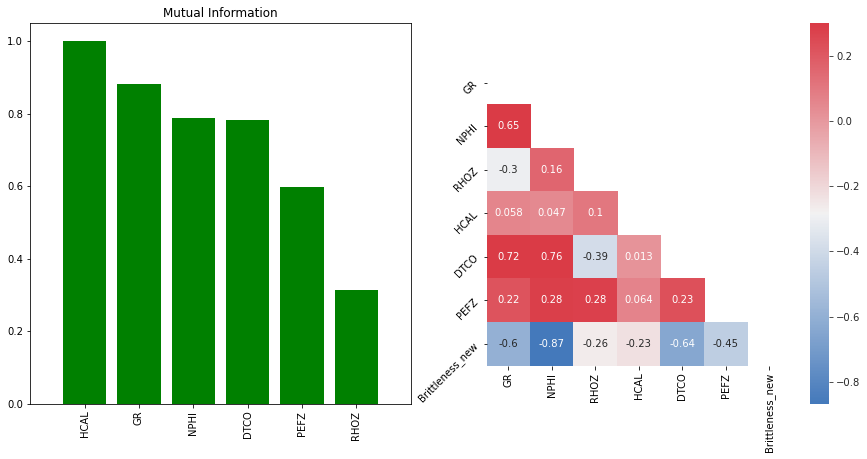

In [16]:
StatRelat(data, target)

In [15]:
data_summary = data.drop(['DEPT'], axis=1).describe().T.round(2)
# data_summary.to_excel(r'./Images/{}.xlsx'.format('data_summary_before_stand'))

In [16]:
data_summary

,count,mean,std,min,25%,50%,75%,max
GR,5793.0,140.87,60.49,24.08,110.99,145.58,164.29,780.63
NPHI,5793.0,0.18,0.07,0.00,0.17,0.20,0.22,0.38
RHOZ,5793.0,2.68,0.07,2.29,2.63,2.69,2.74,3.12
HCAL,5793.0,8.63,0.49,7.59,8.48,8.56,8.85,10.35
DTCO,5793.0,73.64,10.25,49.56,70.04,73.19,79.27,105.45
PEFZ,5793.0,3.97,0.63,2.32,3.70,3.95,4.21,9.70
Brittleness_new,5793.0,0.27,0.13,0.06,0.19,0.23,0.30,0.93


In [17]:
#range
data_summary['max'] - data_summary['min']

GR                 756.55
NPHI                 0.38
RHOZ                 0.83
HCAL                 2.76
DTCO                55.89
PEFZ                 7.38
Brittleness_new      0.87
dtype: float64

In [18]:
#standard deviation
data.std()

DEPT               371.574779
GR                  60.494263
NPHI                 0.067303
RHOZ                 0.074486
HCAL                 0.492982
DTCO                10.250844
PEFZ                 0.630845
Brittleness_new      0.130618
dtype: float64

In [19]:
scaler = MinMaxScaler()
data_norm = pd.DataFrame(scaler.fit_transform(data.drop(['DEPT'], axis=1)), columns = data.drop(['DEPT'], axis=1).columns)
data_norm_summary = data_norm.describe().T.round(2)
data_norm_summary
# data_norm_summary.to_excel(r'./Images/{}.xlsx'.format('data_summary_after_minmax'))

,count,mean,std,min,25%,50%,75%,max
GR,5793.0,0.15,0.08,0.0,0.11,0.16,0.19,1.0
NPHI,5793.0,0.47,0.18,0.0,0.44,0.53,0.58,1.0
RHOZ,5793.0,0.47,0.09,0.0,0.41,0.49,0.54,1.0
HCAL,5793.0,0.37,0.18,0.0,0.32,0.35,0.46,1.0
DTCO,5793.0,0.43,0.18,0.0,0.37,0.42,0.53,1.0
PEFZ,5793.0,0.22,0.09,0.0,0.19,0.22,0.26,1.0
Brittleness_new,5793.0,0.24,0.15,0.0,0.14,0.19,0.28,1.0


In [20]:
scaler = StandardScaler()
data_norm = pd.DataFrame(scaler.fit_transform(data.drop(['DEPT'], axis=1)), columns = data.drop(['DEPT'], axis=1).columns)
data_norm_summary = data_norm.describe().T.round(2)
data_norm_summary
# data_norm_summary.to_excel(r'./Images/{}.xlsx'.format('data_summary_after_standard'))

,count,mean,std,min,25%,50%,75%,max
GR,5793.0,-0.0,1.0,-1.93,-0.49,0.08,0.39,10.58
NPHI,5793.0,0.0,1.0,-2.67,-0.19,0.35,0.62,2.98
RHOZ,5793.0,-0.0,1.0,-5.17,-0.67,0.20,0.80,5.88
HCAL,5793.0,0.0,1.0,-2.10,-0.31,-0.13,0.45,3.50
DTCO,5793.0,-0.0,1.0,-2.35,-0.35,-0.04,0.55,3.10
PEFZ,5793.0,-0.0,1.0,-2.61,-0.42,-0.03,0.38,9.08
Brittleness_new,5793.0,0.0,1.0,-1.57,-0.63,-0.28,0.27,5.09


In [21]:
X = data.drop(['DEPT','RHOZ',target], axis=1)
y = data.loc[:,[target]]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state = 1)

In [22]:
X_train.shape

(4634, 5)

In [23]:
def box_plot(X_train, save_file_name):
    fig, ax = plt.subplots(1,len(X_train.columns), figsize = (15,8))


    for i, feature in enumerate(X_train.columns):
        ax[i].boxplot(X_train[feature])
        ax[i].set_ylabel(feature, fontsize = 20)
        right_side = ax[i].spines["right"]
        top_side = ax[i].spines["top"]
        bottom_side = ax[i].spines["bottom"]



        right_side.set_visible(False)
        top_side.set_visible(False)
        bottom_side.set_visible(False)
        ax[i].axes.get_xaxis().set_visible(False)
#     fig.savefig(r'./Images/{}.png'.format(save_file_name), dpi=300)

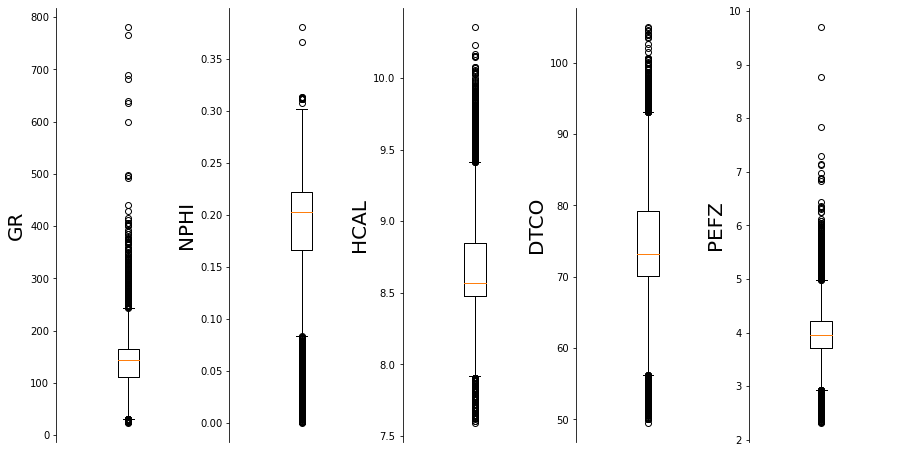

In [24]:
box_plot(X_train, "before_outlier_removal")

In [25]:
# identify outliers in the training dataset
iso = IsolationForest(contamination=0.1)
yhat = iso.fit_predict(X_train)
# select all rows that are not outliers
mask = yhat != -1
X_train, y_train = X_train[mask], y_train[mask]
# summarize the shape of the updated training dataset
print(X_train.shape, y_train.shape)

(4170, 5) (4170, 1)


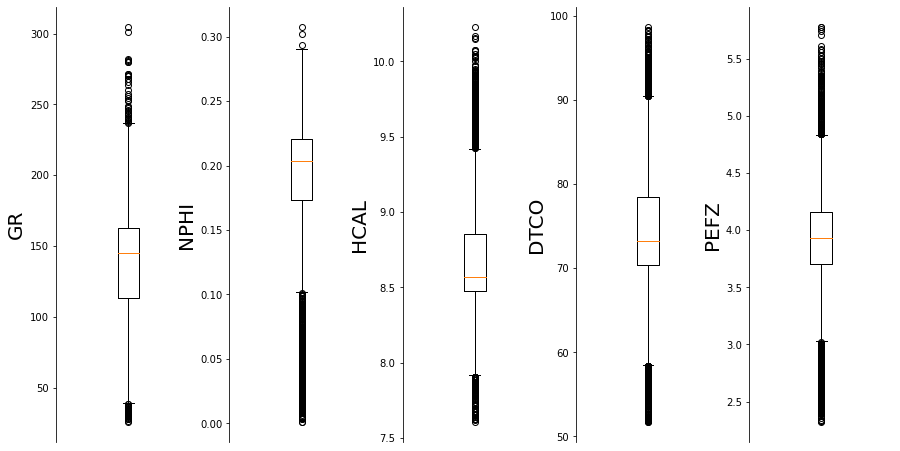

In [26]:
box_plot(X_train, "after_outlier_removal")

In [27]:
df = data_mip3h.loc[: ,features].dropna()
X_blind = df.drop(['DEPT','RHOZ',target], axis=1)
y_blind = df.loc[:,[target]]

# X_blind = data_boggess.loc[: ,features].drop([target], axis=1)
# y_blind = data_boggess.loc[:,[target]]


In [28]:
X_test.shape

(1159, 5)

In [29]:
X_blind.shape

(1998, 5)

## Model Building

In [30]:
def modelfit(X_train, X_test, X_blind, y_train, y_test, y_blind, algorithm, hyper_parameters, scaler, classification,printFeatureImportance=True, cv_folds=3):
    """
    function to tune the gradient boosting model and return the optimum
    
    Parameters
    ----------
    X_train : DataFrame
        The input features for the training set
    X_test : DataFrame
        The input features for the testing set
    X_blind : DataFrame
        The input features for the blind set
    y_train : DataFrame 
        The output feature for the training set
    y_test : DataFrame 
        The output feature for the testing set
    y_blind : DataFrame 
        The output feature for the blind set
    algorithm : {'neural','svm','gradientboosting'}
        The Machine Learning model 
    hyper_parameters : dict
        A dictionary of the hyperparameters of the models that will be tuned
    scaler : {'standard','minmax'}
        Scaling technique to employ.
    classification : bool 
        Flag to specify the modeling technique. True for classification and False for regression
    printFeatureImportance : bool
        Flag to specify if to display the feature importance histogram.
    cv_folds : int
        Number of cross-validation folds. default is 3.
    
    Returns
    -------
    model : an object of the trained gradient boosting which can be deployed or saved
    """   
    #step to assign the selected standardaziation 
    if scaler == 'standard':
        scaler = StandardScaler()
    elif scaler == 'minmax':
        scaler =MinMaxScaler()
    else:
        print("invalid scaler: use 'standard' or 'minmax'")
        
    
    #step to assign the selected machine learning algorithm
    if algorithm == 'svm':
        if classification is True:
            algo = SVC(random_state=83)
        else:
            algo = SVR()
        
    elif algorithm == 'neural':
        if classification is True:
            algo = MLPClassifier(random_state=677)
        else:
            algo = MLPRegressor(random_state=134)
    
    elif algorithm == 'gradientboosting':
        if classification is True:
            algo = gbC(random_state=10)
        else:
            algo = gbR(random_state=824)
    else:
        print("invalid scaler: use 'svm' or 'neural' or 'gradientboosting'")
    
     
        
    if classification is True:
        pipe = Pipeline(steps=[('scaler', scaler), ('model', algo)])
        model = GridSearchCV(estimator = pipe,
                             param_grid = hyper_parameters,
                             scoring='accuracy',n_jobs=-1, cv=cv_folds, verbose = 1)
        
        #Fit the model on the data
        model.fit(X_train.values, y_train.values.ravel())

        #Predict training set:
        y_train_pred = model.predict(X_train)

        #Predict testing set:
        y_test_pred = model.predict(X_test)
        
        #Predict blind set
        y_blind_pred = model.predict(X_blind)

        #Print model report:
        print("Model Report")
        print("-------------------------------")
        print("The training accuracy : {0:.4g}".format(metrics.accuracy_score(y_train.values, y_train_pred)))
        print("The testing accuracy is : {0:.4g}".format(metrics.accuracy_score(y_test.values,y_test_pred)))
        print("The blind well accuracy is : {0:.4g}".format(metrics.accuracy_score(y_blind.values,y_blind_pred)))
        print("CV best score : {0:.4g}".format(model.best_score_))
        print("CV best parameter combinations : {}".format(model.best_params_))
        
        if algorithm == 'gradientboosting':
            #Print Feature Importance:
            if printFeatureImportance:
                feat_imp = pd.Series(model.best_estimator_.named_steps.model.feature_importances_, X_train.columns).sort_values(ascending=False)
                feat_imp.plot(kind='barh', title='Feature Importances')
                plt.xlabel('Feature Importance Score')
           
    else:
        pipe = Pipeline(steps=[('scaler', scaler), ('model', algo)])
        model = GridSearchCV(estimator = pipe,
                             param_grid = hyper_parameters,
                             scoring='r2',n_jobs=-1,
                             cv=cv_folds, verbose = 1)
        
        #Fit the model on the data
        model.fit(X_train.values, y_train.values.ravel())

        #Predict training set:
        y_train_pred = model.predict(X_train)

        #Predict testing set:
        y_test_pred = model.predict(X_test)
                        
        #Predict blind set
        y_blind_pred = model.predict(X_blind)

        #Print model report:
        print("Model Report")
        print("-------------------------------")
        print("The training R2 score : {0:.4g}".format(metrics.r2_score(y_train.values, y_train_pred)))
        print("The testing R2 score is : {0:.4g}".format(metrics.r2_score(y_test.values,y_test_pred)))
        print("The blind well R2 score is : {0:.4g}".format(metrics.r2_score(y_blind.values,y_blind_pred)))
        print("CV best score : {0:.4g}".format(model.best_score_))
        print("CV best parameter combinations : {}".format(model.best_params_))
        
        if algorithm == 'gradientboosting':
            #Print Feature Importance:
            if printFeatureImportance:
                feat_imp = pd.Series(model.best_estimator_.named_steps.model.feature_importances_, X_train.columns).sort_values(ascending=False)
                feat_imp.plot(kind='barh', title='Feature Importances')
                plt.xlabel('Feature Importance Score')

    return model.best_estimator_


In [32]:
"model__min_samples_split" : [2,3,4,5],
                     "model__min_samples_leaf": [1,2,3,4,5],
                     "model__max_depth"        : range(4,8,1)
                    "model__n_estimators"    : range(100,301,50)

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 4)

## Training the Gradient Boosting

In [33]:
#use the documentation of SVR() to understand the parameters
#put new parameters in the grid by using "model__" before the parameter name as below
hyper_parameters =  {
                    }

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.3s finished


Model Report
-------------------------------
The training R2 score : 0.9336
The testing R2 score is : 0.9133
The blind well R2 score is : 0.8141
CV best score : 0.9097
CV best parameter combinations : {}


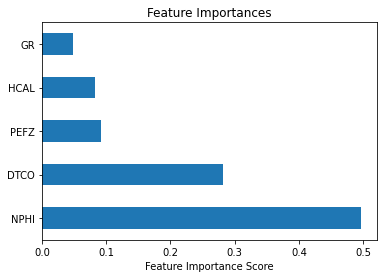

In [34]:
model_gb = modelfit(X_train, X_test, X_blind, y_train, y_test, y_blind, algorithm='gradientboosting', 
             hyper_parameters=hyper_parameters, scaler='minmax', 
             classification=False,printFeatureImportance=True, cv_folds=3)

In [36]:
#sample size vs score 

m = Pipeline(steps=[('scaler', StandardScaler()), ('model', gbR(max_depth= 7, min_samples_leaf= 1, min_samples_split= 3))]) 

size = np.arange(500,X_train.shape[0], 500)

train_scores = []
test_scores = []
blind_scores = []

for i in size:
    m.fit(X_train.iloc[:i,:].values, y_train.iloc[:i,:].values.ravel())
    train_scores.append(metrics.r2_score(y_train.iloc[:i,:].values, m.predict(X_train.iloc[:i,:].values)))
    test_scores.append(metrics.r2_score(y_test.values, m.predict(X_test)))
    blind_scores.append(metrics.r2_score(y_blind.values, m.predict(X_blind)))


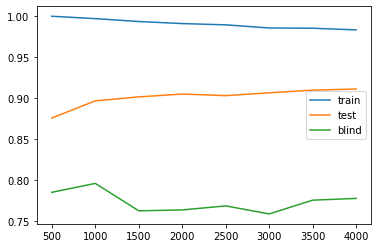

In [37]:
plt.plot(size, train_scores, label = 'train')
plt.plot(size, test_scores, label = 'test')
plt.plot(size, blind_scores, label = 'blind')

plt.legend()

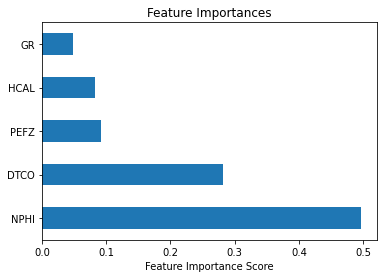

In [39]:
feat_imp = pd.Series(model_gb.named_steps.model.feature_importances_, X_train.columns).sort_values(ascending=False)
feat_imp.plot(kind='barh', title='Feature Importances')
plt.xlabel('Feature Importance Score')
# plt.savefig(r'./Images/{}.png'.format('gb_feature_importance'), dpi=300)

In [ ]:
# model2 = modelfit(X_train2, X_test2, X_blind2, y_train2, y_test2, y_blind2, algorithm='gradientboosting', 
#              hyper_parameters=hyper_parameters, scaler='standard', 
#              classification=True,printFeatureImportance=True, cv_folds=3)

## Training the SVM

In [ ]:
'model__kernel': ['linear', 'poly','rbf','sigmoid']
'model__gamma': ['scale', 'auto']
'model__C': [1,10,100]

In [40]:
#use the documentation of SVR() to understand the parameters
#put new parameters in the grid by using "model__" before the parameter name as below
hyper_parameters = {
                    'model__epsilon': np.arange(0.01,0.1,0.01)}

In [41]:
model_svm = modelfit(X_train, X_test, X_blind, y_train, y_test, y_blind, algorithm='svm', 
         hyper_parameters=hyper_parameters, scaler='standard', 
         classification=False,printFeatureImportance=True, cv_folds=3)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    1.3s finished


Model Report
-------------------------------
The training R2 score : 0.9302
The testing R2 score is : 0.8596
The blind well R2 score is : 0.795
CV best score : 0.9179
CV best parameter combinations : {'model__epsilon': 0.01}


In [42]:
model_svm.named_steps.model.support_vectors_.shape

(2585, 5)

In [ ]:
#sample size vs score 

m = Pipeline(steps=[('scaler', StandardScaler()), ('model', SVR(epsilon=0.02))])

size = np.arange(500,X_train.shape[0], 500)

train_scores = []
test_scores = []
blind_scores = []

for i in size:
    m.fit(X_train.iloc[:i,:].values, y_train.iloc[:i,:].values.ravel())
    train_scores.append(metrics.r2_score(y_train.iloc[:i,:].values, m.predict(X_train.iloc[:i,:].values)))
    test_scores.append(metrics.r2_score(y_test.values, m.predict(X_test)))
    blind_scores.append(metrics.r2_score(y_blind.values, m.predict(X_blind)))

In [ ]:
plt.plot(size, train_scores, label = 'train')
plt.plot(size, test_scores, label = 'test')
plt.plot(size, blind_scores, label = 'blind')

plt.legend()

## Training the Neural Network

In [43]:
#use the documentation of MLPClassifier() to understand the parameters
#put new parameters in the grid by using "model__" before the parameter name as below
hyper_parameters =  {'model__hidden_layer_sizes': [(10,10,),(19,19,),(20,),(20,20,)],
                     'model__tol': [0.0001,0.00001,0.001],
                    'model__solver': ['lbfgs'],
                    'model__max_iter': [1000]}

In [44]:
model_nn = modelfit(X_train, X_test, X_blind, y_train, y_test, y_blind, algorithm='neural', 
         hyper_parameters=hyper_parameters, scaler='minmax', 
         classification=False,printFeatureImportance=True, cv_folds=3)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:   12.7s finished


Model Report
-------------------------------
The training R2 score : 0.9212
The testing R2 score is : 0.9155
The blind well R2 score is : 0.8028
CV best score : 0.9134
CV best parameter combinations : {'model__hidden_layer_sizes': (19, 19), 'model__max_iter': 1000, 'model__solver': 'lbfgs', 'model__tol': 1e-05}


In [ ]:
#sample size vs score 

m = Pipeline(steps=[('scaler', StandardScaler()), ('model', MLPRegressor(hidden_layer_sizes= (19, 19), max_iter= 1000, solver= 'lbfgs', tol= 1e-05))])

size = np.arange(500,X_train.shape[0], 500)

train_scores = []
test_scores = []
blind_scores = []

for i in size:
    m.fit(X_train.iloc[:i,:].values, y_train.iloc[:i,:].values.ravel())
    train_scores.append(metrics.r2_score(y_train.iloc[:i,:].values, m.predict(X_train.iloc[:i,:].values)))
    test_scores.append(metrics.r2_score(y_test.values, m.predict(X_test)))
    blind_scores.append(metrics.r2_score(y_blind.values, m.predict(X_blind)))

In [ ]:
plt.plot(size, train_scores, label = 'train')
plt.plot(size, test_scores, label = 'test')
plt.plot(size, blind_scores, label = 'blind')

plt.legend()

## Visualizing the Result

In [ ]:
#create folder to save images
if os.path.exists(r'./Images'):
    pass
else:
    os.mkdir(r'./Images')

In [53]:
def plot_logs2(data, well_name, model_gb, model_svm, model_nn, formation):
    """
    function to plot the log data and the predictions
    
    Parameters
    ----------
    data : DataFrame
        The well data to be plotted
    well_name : str
        The name of the well being plotted
    model:
        The trained model used for the prediction
    formation : dict
        The formation tops ( names as keys and depth interval as the item in a list)
    
    Returns
    -------
    A plot of the well logs
    """   
    #assigning the logs to variable names to make the code cleaner and easier to read
    MD = data.DEPT
    GR = data.GR
    RHOB = data.RHOZ
    NPHI = data.NPHI
    DT= data.DTCO
    PEFZ = data.PEFZ
    BA = data.Brittleness_new

    #creating the figure
    fig, ax = plt.subplots(nrows=1, ncols=6,figsize=(15,10), sharey=True, gridspec_kw={'width_ratios': [3,3,3,3,3,3]})
        
#     fig.suptitle("O  {}".format(well_name), fontsize=25)
    fig.subplots_adjust(top=0.85, wspace=0.2)

#     ax[0].set_ylim(formation['Upper Marcellus'][0],formation['Lower Marcellus'][1])  #display only a depth range
    ax[0].set_ylim(7600, formation['Lower Marcellus'][1])  #display only a depth range
    ax[0].invert_yaxis()
    ax[0].set_ylabel('MD (M)',fontsize=20)
    ax[0].yaxis.grid(True)
    ax[0].get_xaxis().set_visible(False) #removing the x-axis label at the bottom of the fig

    ##Track 1
    ##Gamma_ray and PEF 
    ax_GR = ax[0].twiny()  #share the depth axis
    ax_GR.set_xlim(0,270)
    ax_GR.plot(GR,MD, color='black')
    ax_GR.set_xlabel('GR (API)',color='black')
    ax_GR.tick_params('x',colors='black')  ##change the color of the x-axis tick label
    ax[0].get_xaxis().set_visible(False)
    ax[0].yaxis.grid(True)
    ax_GR.grid(True,alpha=0.5)

    #variable colorfill
    GR_range = abs(GR.min() - GR.max())
    cmap = plt.get_cmap('nipy_spectral')   #color map
    color_index = np.arange(GR.min(), GR.max(), GR_range / 20)

    #loop through each value in the color_index
    for index in sorted(color_index):
        index_value = (index - GR.min())/GR_range
        color = cmap(index_value) #obtain colour for color index value
        ax_GR.fill_betweenx(MD, 0 , GR, where = GR >= index,  color = color)


    ax_PEFZ = ax[0].twiny()
    ax_PEFZ.plot(PEFZ,MD, color='red')
    ax_PEFZ.set_xlabel('PEFZ',color='red')
    ax_PEFZ.tick_params('x',colors='red')  ##change the color of the x-axis tick label
    ax_PEFZ.spines['top'].set_position(('outward',40)) ##move the x-axis up
    ax_PEFZ.spines["top"].set_edgecolor("red")

    #Track 2
    ##NPHI and RHOB
    ax_NPHI = ax[1].twiny()
    ax_NPHI.set_xlim(-0.1,0.4)
    ax_NPHI.invert_xaxis()
    ax_NPHI.plot(NPHI, MD, label='NPHI[%]', color='green') 
    ax_NPHI.spines['top'].set_position(('outward',0))
    ax_NPHI.set_xlabel('NPHI[%]', color='green')    
    ax_NPHI.tick_params(axis='x', colors='green')
    ax_NPHI.spines["top"].set_edgecolor("green")

    ax_RHOB = ax[1].twiny()
    ax_RHOB.set_xlim(1.95,2.95)
    ax_RHOB.invert_xaxis()
    ax_RHOB.plot(RHOB, MD,label='RHOB[g/cc]', color='red') 
    ax_RHOB.spines['top'].set_position(('outward',40))
    ax_RHOB.set_xlabel('RHOB[g/cc]',color='red')
    ax_RHOB.tick_params(axis='x', colors='red')
    ax_RHOB.spines["top"].set_edgecolor('red')

    ax[1].get_xaxis().set_visible(False)
    ax[1].yaxis.grid(True)
    ax_RHOB.grid(True,alpha=0.5)
    ax[1].axis('off')

    # #color fill
    # x = np.array(ax_RHOB.get_xlim())
    # z = np.array(ax_NPHI.get_xlim())

    # nz=((NPHI-np.max(z))/(np.min(z)-np.max(z)))*(np.max(x)-np.min(x))+np.min(x)

    # ax_RHOB.fill_betweenx(MD, RHOB, nz, where=RHOB>=nz, interpolate=True, color='green')
    # ax_RHOB.fill_betweenx(MD, RHOB, nz, where=RHOB<=nz, interpolate=True, color='yellow')
    

    #Track 3
    ##Sonic 
    ax_DT = ax[2].twiny()
    ax_DT.grid(True)
    ax_DT.set_xlim(100,50)
    ax_DT.spines['top'].set_position(('outward',0))
    ax_DT.plot(DT, MD, label='DT[us/ft]', color='blue')
    ax_DT.set_xlabel('DT[us/ft]', color='blue')    
    ax_DT.tick_params(axis='x', colors='blue')
    ax_DT.spines["top"].set_edgecolor("blue")

    ax[2].get_xaxis().set_visible(False)
    ax[2].yaxis.grid(True)
    ax_DT.grid(True,alpha=0.5)
    ax[2].axis('off')

    #Track 4
    #gb model
    ax_BA1 = ax[3].twiny()
    ax_BA1.grid(True)
    ax_BA1.set_xlim(0,1)
    ax_BA1.spines['top'].set_position(('outward',0))
    ax_BA1.plot(BA, MD, label='BRITTLENESS ESTIMATE', color='black')
    ax_BA1.set_xlabel('BRITTLENESS ESTIMATE', color='black')    
    ax_BA1.tick_params(axis='x', colors='black')

    ##Ploting the predicted data
    ###work on this for generalization
    ax_pred = ax[3].twiny()
    df = data.loc[: , features].dropna()
    pred = model_gb.predict(df.drop(['DEPT','RHOZ',target], axis=1))
    df['Brittleness_predict'] = pred  
    ax_BA1.plot(df.Brittleness_predict, df.DEPT, color='red', linestyle='--')

    ax_pred.spines['top'].set_position(('outward',40))
    ax_pred.set_xlabel('BRITTLENESS (GB)',color='red')
    ax_pred.tick_params(axis='x', colors='red')
    ax_pred.spines["top"].set_edgecolor('red')


    ax[3].get_xaxis().set_visible(False)
    ax[3].yaxis.grid(True)
    ax[3].axis('off')
    ax_BA1.grid(True,alpha=0.5)

    #Track 4
    ##Brittleness
    ## nn model
    ax_BA2 = ax[4].twiny()
    ax_BA2.grid(True)
    ax_BA2.set_xlim(0,1)
    ax_BA2.spines['top'].set_position(('outward',0))
    ax_BA2.plot(BA, MD, label='BRITTLENESS ESTIMATE', color='black')
    ax_BA2.set_xlabel('BRITTLENESS ESTIMATE', color='black')    
    ax_BA2.tick_params(axis='x', colors='black')

    ##Ploting the predicted data
    ###work on this for generalization
    ax_pred = ax[4].twiny()
    df = data.loc[: , features].dropna()
    pred = model_nn.predict(df.drop(['DEPT','RHOZ', target], axis=1))
    df['Brittleness_predict'] = pred  
    ax_BA2.plot(df.Brittleness_predict, df.DEPT, color='blue', linestyle='--')

    ax_pred.spines['top'].set_position(('outward',40))
    ax_pred.set_xlabel('BRITTLENESS (NN)',color='blue')
    ax_pred.tick_params(axis='x', colors='blue')
    ax_pred.spines["top"].set_edgecolor('blue')


    ax[4].get_xaxis().set_visible(False)
    ax[4].yaxis.grid(True)
    ax[4].axis('off')
    ax_BA2.grid(True,alpha=0.5)

    
    #Track 4
    ##Brittleness
    ##svm model
    ax_BA3 = ax[5].twiny()
    ax_BA3.grid(True)
    ax_BA3.set_xlim(0,1)
    ax_BA3.spines['top'].set_position(('outward',0))
    ax_BA3.plot(BA, MD, label='BRITTLENESS ESTIMATE', color='black')
    ax_BA3.set_xlabel('BRITTLENESS ESTIMATE', color='black')    
    ax_BA3.tick_params(axis='x', colors='black')

    ##Ploting the predicted data
    ###work on this for generalization
    ax_pred = ax[5].twiny()
    df = data.loc[: , features].dropna()
    pred = model_svm.predict(df.drop(['DEPT','RHOZ',target], axis=1))
    df['Brittleness_predict'] = pred  
    ax_BA3.plot(df.Brittleness_predict, df.DEPT, color='purple', linestyle='--')

    ax_pred.spines['top'].set_position(('outward',40))
    ax_pred.set_xlabel('BRITTLENESS (SVM)',color='purple')
    ax_pred.tick_params(axis='x', colors='purple')
    ax_pred.spines["top"].set_edgecolor('purple')


    ax[5].get_xaxis().set_visible(False)
    ax[5].yaxis.grid(True)
    ax[5].axis('off')
    ax_BA3.grid(True,alpha=0.5)

    
#     #formation top
#     ax_top = ax[-1]
#     ax[-1].axis('off')

#     formation_midpoints = []
#     for key, value in formation.items():
#         #Calculate mid point of the formation
#         formation_midpoints.append(value[0] + (value[1]-value[0])/2)

#     zone_colours = ["red", "blue", "green"]

#     for ax in [ax_GR, ax_NPHI, ax_BA1, ax_BA2, ax_BA3, ax_top]:
#         # loop through the formations dictionary and zone colours
#         for depth, colour in zip(formation.values(), zone_colours):
#             # use the depths and colours to shade across the subplots
#             ax.axhspan(depth[0], depth[1], color=colour, alpha=0.1)

#     for label, formation_mid in zip(formation.keys(), 
#                                         formation_midpoints):
#         ax_top.text(0.5, formation_mid, label, rotation=90,
#                     verticalalignment='center', horizontalalignment='center', fontweight='bold',
#                     fontsize='large')
#     fig.savefig(r'./Images/{}.png'.format(well_name), dpi=600)

In [ ]:
X_train.columns

In [50]:
# formation = {'Tully': [7195,7310],
#              'Mahantango': [7310,7455],
#             'Marcellus': [7455,7560]}

formation = {'Upper Marcellus': [7453,7476],
             'Middle Marcellus': [7476,7517],
            'Lower Marcellus': [7517,7555]}

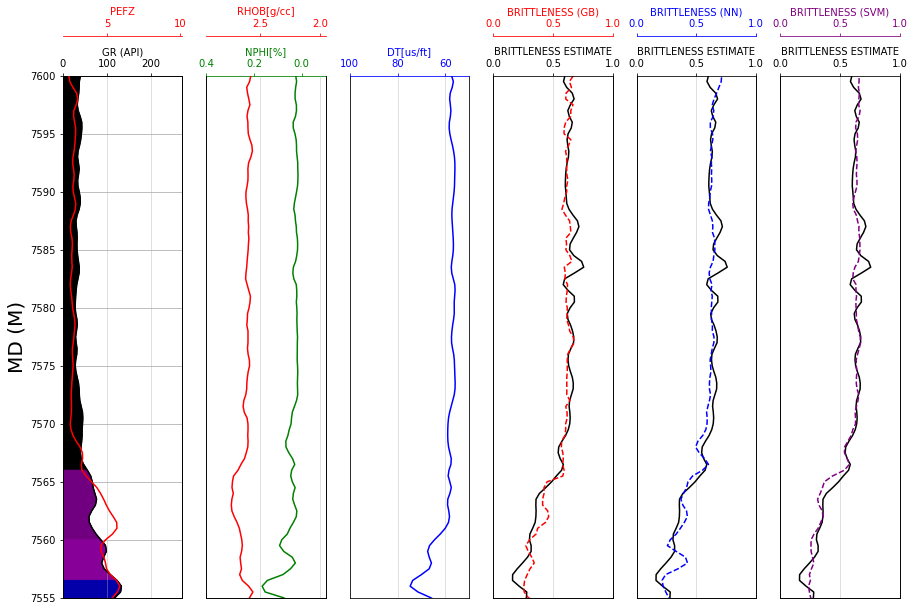

In [51]:
plot_logs2(data_mip3h, "MIP3H2", model_gb, model_svm, model_nn, formation)

In [48]:
# formation2 = {'Tully': [7604,7670],
#              'Mahantango': [7670,7882],
#             'Marcellus': [7882,8052]}
formation_pos = {'Upper Marcellus': [7883,7961],
             'Middle Marcellus': [7961,8015],
            'Lower Marcellus': [8015,8052]}

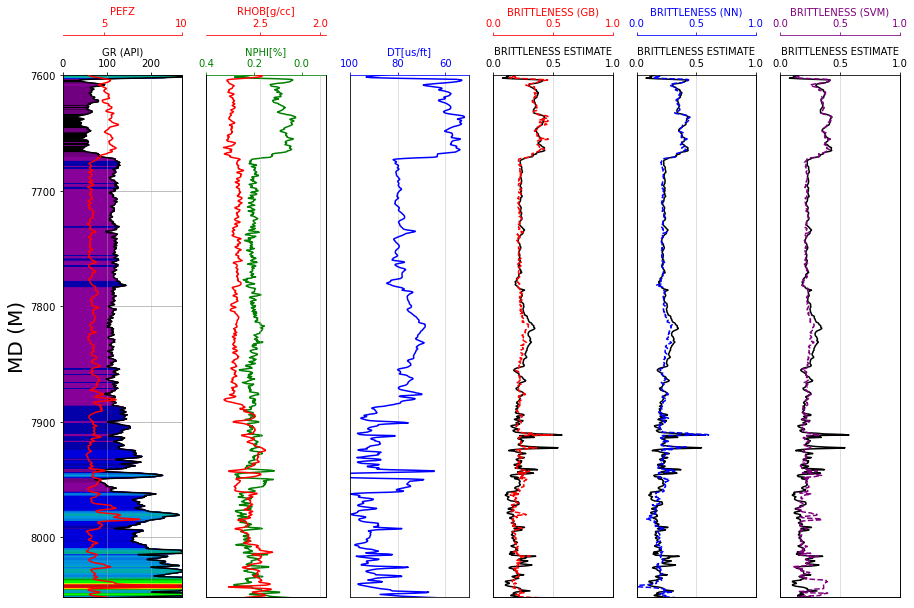

In [49]:
plot_logs2(data_poseidon, "Poseidon", model_gb, model_svm, model_nn, formation_pos)

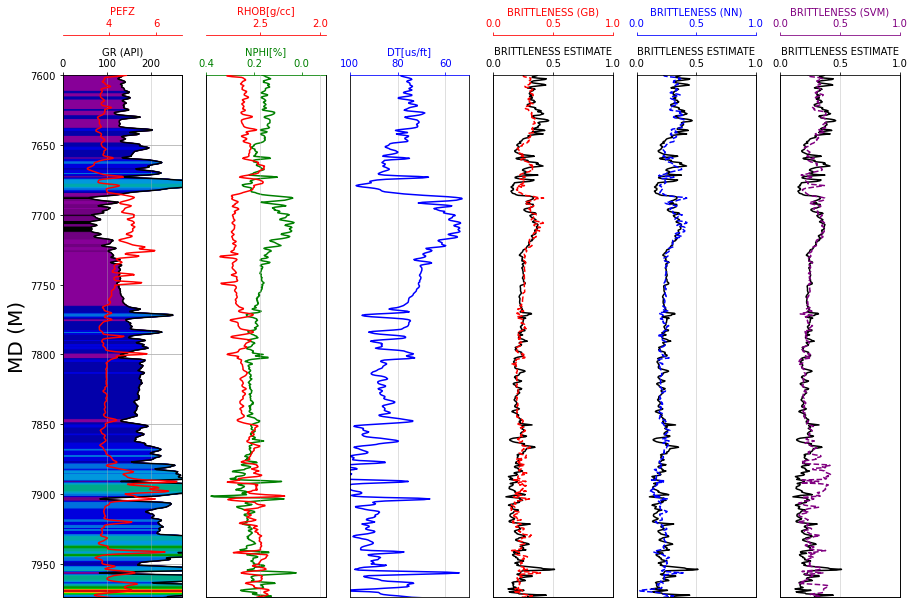

In [54]:
formation_bog = {'Upper Marcellus': [7877,7905],
             'Middle Marcellus': [7905, 7951],
            'Lower Marcellus': [7951,7974]}
plot_logs2(data_boggess, "Boggess", model_gb, model_svm, model_nn, formation_bog)

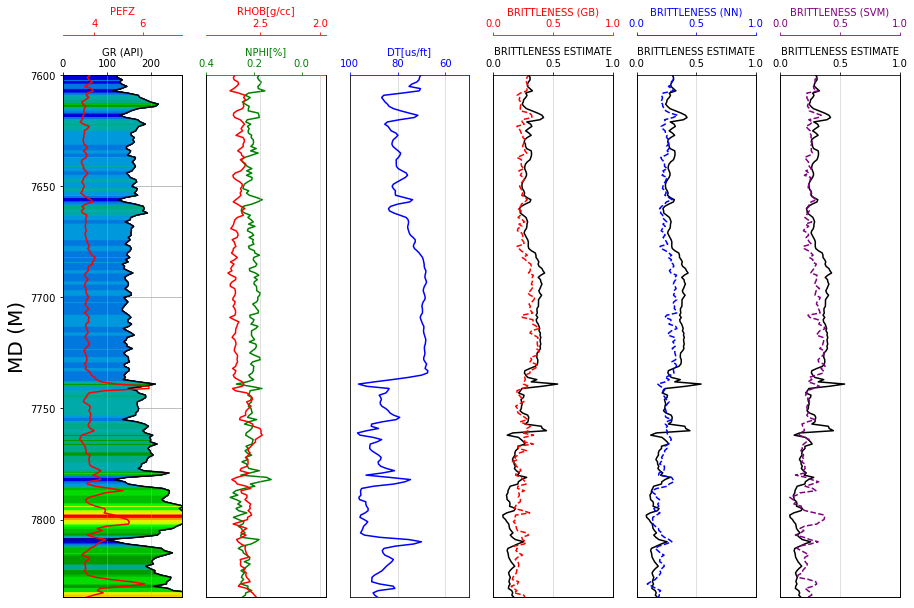

In [52]:
formation_whip = {'Upper Marcellus': [7736, 7785],
             'Middle Marcellus': [7785, 7811],
            'Lower Marcellus': [7811, 7835]}
plot_logs2(data_whipkey, "Whipkey", model_gb, model_svm, model_nn, formation_whip)